# Proyek Analisis Data: Air Quality Dataset

## Menentukan Pertanyaan Analisis

- Bagaimana korelasi antar konsentrasi polutan dengan faktor atmosfer?
- Bagaimana pola fluktuasi kualitas udara di Beijing selama periode 2014 hingga 2016?

## Import Semua Packages/Library yang Digunakan

In [1]:
import imageio, os
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Image

In [2]:
os.makedirs('./dashboard', exist_ok=True)
os.makedirs('./charts', exist_ok=True)

## Data Wrangling

### Gathering Data

In [3]:
data_path = './data/'
files = ['Aotizhongxin.csv', 'Changping.csv', 'Dingling.csv', 'Dongsi.csv', 
         'Guanyuan.csv', 'Gucheng.csv', 'Huairou.csv', 'Nongzhanguan.csv', 
         'Shunyi.csv', 'Tiantan.csv', 'Wanliu.csv', 'Wanshouxigong.csv']
dataframes = {}
for file in files:
    df_name = file.split('.')[0] + '_df'
    dataframes[df_name] = pd.read_csv(os.path.join(data_path, file))
    print(f"Data teratas dari {df_name}:")
    print(dataframes[df_name].head(24), "\n")
    print(f"Data terbawah dari {df_name}:")
    print(dataframes[df_name].tail(24), "\n")

Data teratas dari Aotizhongxin_df:
    No  year  month  day  hour  PM2.5  PM10   SO2   NO2     CO    O3  TEMP  \
0    1  2013      3    1     0    4.0   4.0   4.0   7.0  300.0  77.0  -0.7   
1    2  2013      3    1     1    8.0   8.0   4.0   7.0  300.0  77.0  -1.1   
2    3  2013      3    1     2    7.0   7.0   5.0  10.0  300.0  73.0  -1.1   
3    4  2013      3    1     3    6.0   6.0  11.0  11.0  300.0  72.0  -1.4   
4    5  2013      3    1     4    3.0   3.0  12.0  12.0  300.0  72.0  -2.0   
5    6  2013      3    1     5    5.0   5.0  18.0  18.0  400.0  66.0  -2.2   
6    7  2013      3    1     6    3.0   3.0  18.0  32.0  500.0  50.0  -2.6   
7    8  2013      3    1     7    3.0   6.0  19.0  41.0  500.0  43.0  -1.6   
8    9  2013      3    1     8    3.0   6.0  16.0  43.0  500.0  45.0   0.1   
9   10  2013      3    1     9    3.0   8.0  12.0  28.0  400.0  59.0   1.2   
10  11  2013      3    1    10    3.0   6.0   9.0  12.0  400.0  72.0   1.9   
11  12  2013      3    1    1

**Insight:**
- **Asal sumber data**: 12 stasiun cuaca yang tersebar di berbagai wilayah di Beijing, Tiongkok
- **Periode Pengukuran**: Maret 2013 hingga Februari 2017
- **Frekuensi Pengukuran**: Setiap jam
- **Dataset _Air Quality_ ini mencakup pengukuran yang meliputi**: Partikulat Materi (PM 2.5 dan 10 mikrometer), Gas Polutan (Sulfur dioksida SO2, Nitrogen dioksida NO2, Karbon monoksida CO, Ozon O3), dan Parameter Meteorologi (Temperatur, Tekanan Udara, Arah Angin (wd), Titik Embun (DEWP), Kecepatan Angin (WSPM))

In [4]:
geo_map = gpd.read_file('./data/geoBoundaries-CHN-ADM3_simplified.shp')
geo_map.info()
geo_map.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2864 entries, 0 to 2863
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   shapeName   2864 non-null   object  
 1   shapeISO    0 non-null      object  
 2   shapeID     2864 non-null   object  
 3   shapeGroup  2864 non-null   object  
 4   shapeType   2864 non-null   object  
 5   geometry    2864 non-null   geometry
dtypes: geometry(1), object(5)
memory usage: 134.4+ KB


,shapeName,shapeISO,shapeID,shapeGroup,shapeType,geometry
0,Luzhai County,None,62558664B54494607263506,CHN,ADM3,"POLYGON ((109.51762 24.76566, 109.52818 24.777..."
1,Fengnan District,None,62558664B67620620210469,CHN,ADM3,"POLYGON ((117.92804 39.57315, 117.96054 39.563..."
2,Funing County,None,62558664B49289767842634,CHN,ADM3,"POLYGON ((105.50644 24.0277, 105.50772 24.0294..."
3,Hongxing District,None,62558664B29551905418573,CHN,ADM3,"POLYGON ((128.97754 48.47922, 129.01811 48.469..."
4,Wangqing County,None,62558664B88242467418806,CHN,ADM3,"POLYGON ((129.09032 43.54665, 129.14523 43.566..."


**Insight:**
- **Dataset `geoBoundaries-CHN-ADM3_simplified` dari https://data.humdata.org/dataset/geoboundaries-admin-boundaries-for-china berisi data batas administratif tingkat 3 di Tiongkok (kabupaten dan distrik)**, dengan kolom penting shapeName (nama wilayah) dan geometry (batas wilayah dalam bentuk poligon). Dataset ini berguna untuk analisis spasial, seperti memantau kualitas udara. Dengan menggabungkan data ini dengan data stasiun pemantauan udara, kita bisa memetakan lokasi stasiun, menghubungkan wilayah dengan data polusi, dan melakukan analisis spasial kualitas udara

### Assessing Data

In [5]:
for file in files:
    df_name = file.split('.')[0] + '_df'
    print(f"Informasi data dari {df_name}:")
    print(dataframes[df_name].info(), "\n")

Informasi data dari Aotizhongxin_df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 18 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   No       35064 non-null  int64  
 1   year     35064 non-null  int64  
 2   month    35064 non-null  int64  
 3   day      35064 non-null  int64  
 4   hour     35064 non-null  int64  
 5   PM2.5    34139 non-null  float64
 6   PM10     34346 non-null  float64
 7   SO2      34129 non-null  float64
 8   NO2      34041 non-null  float64
 9   CO       33288 non-null  float64
 10  O3       33345 non-null  float64
 11  TEMP     35044 non-null  float64
 12  PRES     35044 non-null  float64
 13  DEWP     35044 non-null  float64
 14  RAIN     35044 non-null  float64
 15  wd       34983 non-null  object 
 16  WSPM     35050 non-null  float64
 17  station  35064 non-null  object 
dtypes: float64(11), int64(5), object(2)
memory usage: 4.8+ MB
None 

Informasi data dari Chan

In [6]:
for file in files:
    df_name = file.split('.')[0] + '_df'
    print(f"Missing values dari {df_name}:")
    print(dataframes[df_name].isna().sum(), "\n")

Missing values dari Aotizhongxin_df:
No            0
year          0
month         0
day           0
hour          0
PM2.5       925
PM10        718
SO2         935
NO2        1023
CO         1776
O3         1719
TEMP         20
PRES         20
DEWP         20
RAIN         20
wd           81
WSPM         14
station       0
dtype: int64 

Missing values dari Changping_df:
No            0
year          0
month         0
day           0
hour          0
PM2.5       774
PM10        582
SO2         628
NO2         667
CO         1521
O3          604
TEMP         53
PRES         50
DEWP         53
RAIN         51
wd          140
WSPM         43
station       0
dtype: int64 

Missing values dari Dingling_df:
No            0
year          0
month         0
day           0
hour          0
PM2.5       779
PM10        656
SO2         730
NO2        1234
CO         2012
O3         1214
TEMP         53
PRES         50
DEWP         53
RAIN         51
wd          140
WSPM         43
station       0
dt

In [7]:
for file in files:
    df_name = file.split('.')[0] + '_df'
    print(f"Jumlah duplikasi dari {df_name}: {dataframes[df_name].duplicated().sum()}")

Jumlah duplikasi dari Aotizhongxin_df: 0
Jumlah duplikasi dari Changping_df: 0
Jumlah duplikasi dari Dingling_df: 0
Jumlah duplikasi dari Dongsi_df: 0
Jumlah duplikasi dari Guanyuan_df: 0
Jumlah duplikasi dari Gucheng_df: 0
Jumlah duplikasi dari Huairou_df: 0
Jumlah duplikasi dari Nongzhanguan_df: 0
Jumlah duplikasi dari Shunyi_df: 0
Jumlah duplikasi dari Tiantan_df: 0
Jumlah duplikasi dari Wanliu_df: 0
Jumlah duplikasi dari Wanshouxigong_df: 0


In [8]:
for file in files:
    df_name = file.split('.')[0] + '_df'
    print(f"Statistika deskriptif dari {df_name}:")
    print(dataframes[df_name].describe(), "\n")

Statistika deskriptif dari Aotizhongxin_df:
                 No          year         month           day          hour  \
count  35064.000000  35064.000000  35064.000000  35064.000000  35064.000000   
mean   17532.500000   2014.662560      6.522930     15.729637     11.500000   
std    10122.249256      1.177213      3.448752      8.800218      6.922285   
min        1.000000   2013.000000      1.000000      1.000000      0.000000   
25%     8766.750000   2014.000000      4.000000      8.000000      5.750000   
50%    17532.500000   2015.000000      7.000000     16.000000     11.500000   
75%    26298.250000   2016.000000     10.000000     23.000000     17.250000   
max    35064.000000   2017.000000     12.000000     31.000000     23.000000   

              PM2.5          PM10           SO2           NO2            CO  \
count  34139.000000  34346.000000  34129.000000  34041.000000  33288.000000   
mean      82.773611    110.060391     17.375901     59.305833   1262.945145   
std    

**Insight:**
- Terdapat 35064 baris data atau dengan kata lain terdapat 35064 jam (1461 hari) pengukuran dengan tipe data kuantitatif pada seluruh parameter kecuali arah angin (wind direction) dan variabel stasiun cuaca
- Dari total 35064 baris data pada masing-masing data frame, sebanyak 3197 data (sekitar 9.1%) tidak memiliki nilai untuk parameter CO pada dataframe Dongsi
- Tiap data bersifat unik karena jumplah duplikasi data bernilai 0 untuk semua dataframe dan tidak ditemukan data yang tidak akurat
- Data cenderung memiliki kemiringan (skewness) atau kurtosis, serta terdapat nilai ekstrem (outliers) yang mempengaruhi karakteristik keseluruhan distribusi

In [9]:
geo_map.isna().sum()

shapeName        0
shapeISO      2864
shapeID          0
shapeGroup       0
shapeType        0
geometry         0
dtype: int64

**Insight:** Missing value pada shapeISO dapat diabaikan karena kolom ini tidak digunakan

### Cleaning Data

In [10]:
for file in files:
    df_name = file.split('.')[0] + '_df'
    for column_name in ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']:
        dataframes[df_name][column_name] = dataframes[df_name][column_name].interpolate(method='linear')

In [11]:
for file in files:
    df_name = file.split('.')[0] + '_df'
    dataframes[df_name] = dataframes[df_name].query('2014 <= year <= 2016')
    dataframes[df_name] = dataframes[df_name].drop(columns=['No', 'wd'])

In [12]:
for file in files:
    df_name = file.split('.')[0] + '_df'
    print(f"Missing values dari {df_name}:")
    print(dataframes[df_name].isna().sum(), "\n")

Missing values dari Aotizhongxin_df:
year       0
month      0
day        0
hour       0
PM2.5      0
PM10       0
SO2        0
NO2        0
CO         0
O3         0
TEMP       0
PRES       0
DEWP       0
RAIN       0
WSPM       0
station    0
dtype: int64 

Missing values dari Changping_df:
year       0
month      0
day        0
hour       0
PM2.5      0
PM10       0
SO2        0
NO2        0
CO         0
O3         0
TEMP       0
PRES       0
DEWP       0
RAIN       0
WSPM       0
station    0
dtype: int64 

Missing values dari Dingling_df:
year       0
month      0
day        0
hour       0
PM2.5      0
PM10       0
SO2        0
NO2        0
CO         0
O3         0
TEMP       0
PRES       0
DEWP       0
RAIN       0
WSPM       0
station    0
dtype: int64 

Missing values dari Dongsi_df:
year       0
month      0
day        0
hour       0
PM2.5      0
PM10       0
SO2        0
NO2        0
CO         0
O3         0
TEMP       0
PRES       0
DEWP       0
RAIN       0
WSPM       0
s

In [13]:
for file in files:
    df_name = file.split('.')[0] + '_df'
    print(f"Data teratas dari {df_name}:")
    print(dataframes[df_name].head(24), "\n")
    print(f"Data terbawah dari {df_name}:")
    print(dataframes[df_name].tail(24), "\n")

Data teratas dari Aotizhongxin_df:
      year  month  day  hour  PM2.5   PM10   SO2    NO2      CO    O3  TEMP  \
7344  2014      1    1     0   20.0   90.0  18.0   62.0   950.0   7.0  -1.5   
7345  2014      1    1     1   43.0  348.0  25.0   91.0  1100.0   1.0  -2.6   
7346  2014      1    1     2   79.0  423.0  41.0  103.0  1800.0   1.0  -3.0   
7347  2014      1    1     3   82.0  337.0  43.0  101.0  2100.0   1.0  -3.3   
7348  2014      1    1     4  124.0  594.0  59.0  130.0  2400.0   1.0  -2.7   
7349  2014      1    1     5   89.0  307.0  47.0  102.0  2500.0   1.0  -3.1   
7350  2014      1    1     6   59.0  161.0  45.0   91.0  1900.0   1.0  -2.6   
7351  2014      1    1     7   31.0   93.0  24.0   69.0   900.0   4.0  -2.9   
7352  2014      1    1     8   21.0   90.0  18.0   52.0   700.0  17.0   0.0   
7353  2014      1    1     9   38.0  142.0  25.0   87.0  1200.0   1.0   9.0   
7354  2014      1    1    10   33.0  130.0  27.0   63.0  1200.0  16.0  10.3   
7355  2014      1

In [14]:
geo_map = geo_map.drop(columns=['shapeISO', 'shapeID', 'shapeGroup', 'shapeType'])
geo_map.info()
geo_map.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2864 entries, 0 to 2863
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   shapeName  2864 non-null   object  
 1   geometry   2864 non-null   geometry
dtypes: geometry(1), object(1)
memory usage: 44.9+ KB


,shapeName,geometry
0,Luzhai County,"POLYGON ((109.51762 24.76566, 109.52818 24.777..."
1,Fengnan District,"POLYGON ((117.92804 39.57315, 117.96054 39.563..."
2,Funing County,"POLYGON ((105.50644 24.0277, 105.50772 24.0294..."
3,Hongxing District,"POLYGON ((128.97754 48.47922, 129.01811 48.469..."
4,Wangqing County,"POLYGON ((129.09032 43.54665, 129.14523 43.566..."


In [15]:
geo_map = geo_map[~geo_map['shapeName'].str.contains('County', case=False, na=False)]
stations = ['Aotizhongxin', 'Changping', 'Dingling', 'Dongsi', 'Guanyuan', 'Gucheng', 'Huairou', 'Nongzhanguan', 'Shunyi', 'Tiantan', 'Wanliu', 'Wanshouxigong']
district = ['Chaoyang', 'Changping', 'Changping', 'Dongcheng', 'Xicheng', 'Shijingshan', 'Huairou', 'Chaoyang', 'Shunyi', 'Dongcheng', 'Haidian', 'Xicheng']
beijing_map = geo_map[geo_map['shapeName'].str.contains('|'.join(district), case=False, na=False)]
beijing_map = beijing_map[(beijing_map['shapeName'] != 'Chaoyang District') | (beijing_map.index == 184)]

**Insight:**
- **Tidak dilakukan imputasi dengan median atau mean** karena kedua metode ini hanya memberikan nilai pusat dari data yang tidak memperhitungkan tren atau pola yang mungkin ada dalam data yang dapat menghasilkan nilai yang tidak sesuai dengan pola tersebut
- **Interpolasi linear digunakan untuk variabel seperti partikulat materi, gas polutan, dan parameter meteorologi** karena variabel-variabel ini sering kali berubah dalam waktu tertentu yang memungkinkan untuk menangkap variasi yang terjadi dan menghindari nilai negatif pada variabel lingkungan yang memiliki batasan fisik. Selain itu, interpolasi linear juga dapat mencegah overfitting dan cepat dalam implementasinya
- **Menghapus data tahun 2013 dan 2017** karena data dari 12 bulan di kedua tahun tersebut tidak ada secara penuh yang dapat menyebabkan bias dalam analisis
- Kolom wind direction (arah angin) tidak bersifat numerik, melainkan kategorikal selain itu variabel ini tidak mudah digunakan karena memerlukan metode pemrosesan khusus sementara dalam analisis ini berfokus pada data numerik yang lebih relevan untuk eksplorasi, deteksi outlier, korelasi, dan visualisasi seperti boxplot atau time series sehingga **menghapus variabel wind direction cukup relevan**
- Selain itu, **kolom nomor di setiap dataframe dihapus** karena tidak memiliki nilai informasi yang signifikan dalam analisis. Sebagai gantinya, tanggal (kombinasi tahun, bulan, hari) digunakan sebagai primary key untuk mengidentifikasi setiap pengukuran unik. Ini lebih relevan untuk analisis time series, di mana fokusnya adalah pada perubahan data polusi dan meteorologi berdasarkan waktu, bukan urutan entri data
- **Pembersihan dataset geografi** dengan menghapus kolom yang tidak relevan seperti shapeISO, shapeID, shapeGroup, dan shapeType. Selain itu, menyaring data untuk mencakup hanya distrik yang relevan di Beijing dan memilih hanya satu entri spesifik untuk Chaoyang District, yaitu yang memiliki index 184, karena memastikan penggunaan data yang paling relevan

## Exploratory Data Analysis (EDA)

### Informasi umum masing-masing dataframe seperti kolom, tipe data, dan penggunaan memory untuk dataset _air quality_

In [16]:
for file in files:
    df_name = file.split('.')[0] + '_df'
    print(f"Statistika deskriptif dari {df_name}:")
    print(dataframes[df_name].info(), "\n")

Statistika deskriptif dari Aotizhongxin_df:
<class 'pandas.core.frame.DataFrame'>
Index: 26304 entries, 7344 to 33647
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   year     26304 non-null  int64  
 1   month    26304 non-null  int64  
 2   day      26304 non-null  int64  
 3   hour     26304 non-null  int64  
 4   PM2.5    26304 non-null  float64
 5   PM10     26304 non-null  float64
 6   SO2      26304 non-null  float64
 7   NO2      26304 non-null  float64
 8   CO       26304 non-null  float64
 9   O3       26304 non-null  float64
 10  TEMP     26304 non-null  float64
 11  PRES     26304 non-null  float64
 12  DEWP     26304 non-null  float64
 13  RAIN     26304 non-null  float64
 14  WSPM     26304 non-null  float64
 15  station  26304 non-null  object 
dtypes: float64(11), int64(4), object(1)
memory usage: 3.4+ MB
None 

Statistika deskriptif dari Changping_df:
<class 'pandas.core.frame.DataFrame'>
Index: 26304 ent

### Eksplorasi statistika deskriptif masing-masing dataframe untuk dataset _air quality_

In [17]:
for file in files:
    df_name = file.split('.')[0] + '_df'
    print(f"Statistika deskriptif dari {df_name}:")
    print(dataframes[df_name].describe(), "\n")

Statistika deskriptif dari Aotizhongxin_df:
               year         month           day          hour         PM2.5  \
count  26304.000000  26304.000000  26304.000000  26304.000000  26304.000000   
mean    2015.000912      6.521898     15.732664     11.500000     81.931642   
std        0.816698      3.449052      8.801537      6.922318     82.010766   
min     2014.000000      1.000000      1.000000      0.000000      3.000000   
25%     2014.000000      4.000000      8.000000      5.750000     22.000000   
50%     2015.000000      7.000000     16.000000     11.500000     57.000000   
75%     2016.000000     10.000000     23.000000     17.250000    113.000000   
max     2016.000000     12.000000     31.000000     23.000000    898.000000   

               PM10           SO2           NO2            CO            O3  \
count  26304.000000  26304.000000  26304.000000  26304.000000  26304.000000   
mean     109.621031     15.563517     57.493562   1271.200198     58.021156   
std    

In [18]:
for file in files:
    df_name = file.split('.')[0] + '_df'
    print(f'\n{df_name}')
    for column_name in ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']:
        print(f'{column_name} skew = {round(dataframes[df_name][column_name].skew(), 1)} and kurt = {round(dataframes[df_name][column_name].kurt(), 1)}')


Aotizhongxin_df
PM2.5 skew = 2.0 and kurt = 5.8
PM10 skew = 1.9 and kurt = 5.9
SO2 skew = 3.1 and kurt = 13.8
NO2 skew = 1.0 and kurt = 1.2
CO skew = 2.8 and kurt = 10.4
O3 skew = 1.4 and kurt = 2.0
TEMP skew = -0.1 and kurt = -1.2
PRES skew = 0.1 and kurt = -0.9
DEWP skew = -0.2 and kurt = -1.1
RAIN skew = 27.1 and kurt = 950.9
WSPM skew = 1.3 and kurt = 2.4

Changping_df
PM2.5 skew = 2.0 and kurt = 5.3
PM10 skew = 2.2 and kurt = 8.9
SO2 skew = 3.3 and kurt = 15.1
NO2 skew = 1.2 and kurt = 1.4
CO skew = 2.8 and kurt = 10.8
O3 skew = 1.5 and kurt = 2.8
TEMP skew = -0.1 and kurt = -1.1
PRES skew = 0.1 and kurt = -0.9
DEWP skew = -0.2 and kurt = -1.1
RAIN skew = 31.3 and kurt = 1403.4
WSPM skew = 1.7 and kurt = 3.4

Dingling_df
PM2.5 skew = 2.1 and kurt = 6.1
PM10 skew = 2.2 and kurt = 8.9
SO2 skew = 2.9 and kurt = 11.6
NO2 skew = 1.7 and kurt = 3.4
CO skew = 2.8 and kurt = 12.1
O3 skew = 2.0 and kurt = 6.7
TEMP skew = -0.1 and kurt = -1.1
PRES skew = 0.1 and kurt = -0.9
DEWP skew = -0.

**Insight:**
- **Dominasi distribusi tidak normal dan tidak simetris terutama pada polutan udara (PM2.5, PM10, SO2, NO2, CO, O3)** yang memiliki distribusi yang sangat menyimpang dari distribusi normal dengan nilai skewness yang positif dan kurtosis yang tinggi yang berarti data cenderung memiliki banyak nilai ekstrem
- **Variabel meteorologi seperti curah hujan dan kecepatan angin juga menunjukkan distribusi yang tidak normal** dengan banyak nilai ekstrem **sementara itu variable meteorologi lain seperti suhu dan tekanan udara lebih simetris**

### Mengkombinasikan seluruh dataframe dan kalkulasi indeks polusi berdasarkan batas atas rekomendasi WHO

In [19]:
combined_df = pd.DataFrame()
for df_name, df in dataframes.items():
    df = df.drop(columns=['station'])
    df_grouped = df.groupby(['year', 'month', 'day']).mean().reset_index()
    df_grouped['station'] = df_name.split('_')[0]
    combined_df = pd.concat([combined_df, df_grouped])
combined_df['datetime'] = pd.to_datetime(combined_df[['year', 'month', 'day']])
combined_df = combined_df.drop(columns=['year', 'month', 'day', 'hour'])
combined_df = combined_df[['datetime', 'station'] + [col for col in combined_df.columns if col not in ['datetime', 'station']]]
combined_df = combined_df.round(1)
pollutant_limits = {'PM2.5': 15, 'PM10': 45, 'SO2': 40, 'NO2': 25, 'CO': 4000, 'O3': 100}
pollutants = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3']
normalized_pollutants = pd.DataFrame()
for pollutant in pollutants:
    normalized_pollutants[pollutant] = combined_df[pollutant] / pollutant_limits[pollutant]
combined_df['PI'] = round(normalized_pollutants.mean(axis=1) + normalized_pollutants.max(axis=1), 2)
combined_df.to_csv('./dashboard/main_data.csv', index=False)
main_df = pd.read_csv('./dashboard/main_data.csv')

In [20]:
main_df.head(30)

,datetime,station,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,PI
0,2014-01-01,Aotizhongxin,48.6,169.2,27.4,69.5,1406.2,18.8,2.7,1009.0,-10.6,0.0,1.3,5.59
1,2014-01-02,Aotizhongxin,151.7,192.2,90.6,93.7,3437.5,1.2,2.1,1012.5,-6.5,0.0,1.0,13.66
2,2014-01-03,Aotizhongxin,50.5,114.7,33.9,48.1,1083.3,25.0,4.1,1016.6,-10.8,0.0,2.1,4.90
3,2014-01-04,Aotizhongxin,121.5,158.2,55.2,78.6,2304.2,1.1,-0.8,1016.7,-5.1,0.0,1.3,10.89
4,2014-01-05,Aotizhongxin,90.1,116.8,42.4,70.7,1850.0,11.2,0.5,1018.7,-8.7,0.0,1.7,8.18
5,2014-01-06,Aotizhongxin,125.2,131.9,60.2,67.1,2033.3,2.8,-0.9,1019.8,-4.1,0.0,1.6,11.01
6,2014-01-07,Aotizhongxin,105.0,99.1,44.9,61.1,1670.8,13.5,1.7,1021.3,-11.1,0.0,2.2,9.22
7,2014-01-08,Aotizhongxin,15.2,16.0,16.5,20.9,566.7,34.4,-1.9,1027.7,-19.9,0.0,2.7,1.53
8,2014-01-09,Aotizhongxin,36.0,42.9,24.4,39.5,804.2,23.2,-2.9,1025.6,-22.4,0.0,2.1,3.40
9,2014-01-10,Aotizhongxin,60.6,88.6,57.9,75.6,1641.7,3.1,-3.4,1024.7,-18.5,0.0,1.4,5.86


In [21]:
main_df.tail(30)

,datetime,station,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,PI
13122,2016-12-02,Wanshouxigong,130.4,140.7,23.4,96.3,2091.7,6.5,3.1,1025.3,-7.1,0.0,1.0,11.50
13123,2016-12-03,Wanshouxigong,236.1,246.1,22.8,124.7,3504.2,4.8,2.1,1017.2,-3.5,0.0,0.9,20.36
13124,2016-12-04,Wanshouxigong,323.5,334.2,15.8,124.6,4129.2,7.1,2.9,1013.0,-2.1,0.0,0.7,27.48
13125,2016-12-05,Wanshouxigong,46.5,53.5,7.0,47.8,1029.2,28.2,2.6,1023.6,-11.4,0.0,2.4,4.25
13126,2016-12-06,Wanshouxigong,85.9,119.0,21.5,97.5,2116.7,5.0,0.0,1019.1,-11.7,0.0,0.9,7.96
13127,2016-12-07,Wanshouxigong,150.4,180.5,25.9,115.3,2962.5,4.3,3.0,1019.3,-6.0,0.0,1.6,13.37
13128,2016-12-08,Wanshouxigong,106.8,133.9,14.2,61.7,1891.7,33.2,4.4,1014.3,-8.8,0.0,2.6,9.41
13129,2016-12-09,Wanshouxigong,25.8,38.5,9.2,43.7,758.3,31.4,1.5,1024.3,-12.5,0.0,1.6,2.59
13130,2016-12-10,Wanshouxigong,53.6,73.3,14.9,71.4,1408.3,7.5,-0.7,1025.3,-11.0,0.0,0.9,5.05
13131,2016-12-11,Wanshouxigong,193.2,204.6,36.7,109.5,3243.8,4.9,-0.7,1021.2,-6.7,0.0,1.2,16.81


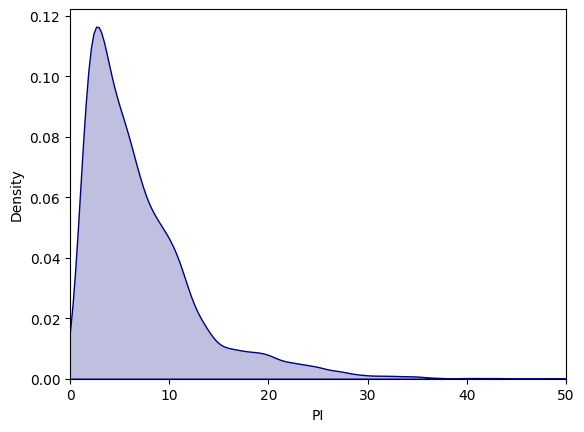

count    13152.000000
mean         7.172851
std          5.847724
min          0.530000
25%          3.010000
50%          5.530000
75%          9.470000
max         47.570000
Name: PI, dtype: float64

In [22]:
sns.kdeplot(main_df['PI'], color='navy', fill=True)
plt.xlim(0, 50)
plt.show()
main_df['PI'].describe()

**Insight:**
- **Setiap pengukuran parameter kualitas udara dihitung rata-ratanya berdasarkan waktu (year, month, day)**. Dengan memanfaatkan rata-rata data yang dapat dipengaruhi oleh nilai ekstrim (outliers) memberikan keuntungan karena dapat merekam lonjakan polutan pada kondisi tertentu, sehingga rata-rata yang tercatat masih mengandung informasi berharga mengenai perubahan drastis dalam kualitas udara
- **Dilakukan pembulatan sesuai dengan aturan angka penting yang umum digunakan dalam pengukuran ilmiah**. Alat-alat pengukur biasanya memiliki keterbatasan presisi, sehingga tidak relevan untuk mencatat nilai dengan lebih dari satu angka di belakang koma. Selain itu, pembulatan membantu mengurangi ukuran dataset, menekan penggunaan ruang penyimpanan
- **Penggabungan kolom day, month, dan year ke dalam satu kolom datetime** agar lebih fleksibel dan efisien dalam analisis waktu
- **Digunakan formula berdasarkan normalisasi terhadap batas polutan yang disarankan oleh WHO**. Pendekatan ini berbeda dari metode AQI tradisional yang sering digunakan di berbagai negara, seperti AS atau India. Pendekatan ini lebih mengutamakan panduan kualitas udara global yang dianggap sehat untuk kesehatan manusia menurut standar WHO Air Quality Guidelines (AQG) yang bersumber dari https://www.who.int/news-room/feature-stories/detail/what-are-the-who-air-quality-guidelines
- **Formula ini menghitung rata-rata kontribusi dari semua polutan yang dinormalisasi dan juga mempertimbangkan polutan dengan kontribusi tertinggi**. Dengan menggabungkan rata-rata dan nilai maksimum, dipertimbangkan antara memperhitungkan kombinasi polutan dan tetap menyoroti polutan yang paling berbahaya pada saat itu. Hal ini dapat memberikan gambaran yang lebih komprehensif tentang kualitas udara secara keseluruhan
- **Dalam klasifikasi PI (Pollution Index), digunakan**:
    * **0 ≤ PI < 2, Sehat (Good):** Sebagian besar polutan masih di bawah batas WHO, namun ada beberapa polutan yang sedikit mendekati batas
    * **2 ≤ PI < 3, Sedang (Moderate):** Beberapa polutan mendekati batas WHO, atau satu polutan mendekati atau sedikit melebihi batas aman WHO. Risiko bagi individu sensitif mulai muncul
    * **3 ≤ PI < 4, Tidak Sehat untuk Kelompok Sensitif (Unhealthy for Sensitive Groups):** Ada beberapa polutan yang melewati batas WHO atau satu polutan secara signifikan melampaui batas. Orang dengan kondisi kesehatan tertentu mungkin mengalami dampak kesehatan
    * **4 ≤ PI < 6, Tidak Sehat (Unhealthy):** Beberapa polutan melampaui batas WHO, dan kualitas udara mulai membahayakan kesehatan sebagian besar penduduk
    * **PI ≥ 6, Sangat Tidak Sehat/Berbahaya (Very Unhealthy/Hazardous):** Kualitas udara buruk dengan polutan yang melampaui batas WHO secara signifikan. Risiko kesehatan tinggi untuk seluruh populasi
- **Separuh waktu kualitas udara di Beijing masuk kategori "tidak sehat" bagi populasi umum** yang ditunjukkan dengan median di 5.53

### Informasi umum dan eksplorasi statistika deskriptif dari dataframe utama

In [23]:
print(main_df.info())
main_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13152 entries, 0 to 13151
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   datetime  13152 non-null  object 
 1   station   13152 non-null  object 
 2   PM2.5     13152 non-null  float64
 3   PM10      13152 non-null  float64
 4   SO2       13152 non-null  float64
 5   NO2       13152 non-null  float64
 6   CO        13152 non-null  float64
 7   O3        13152 non-null  float64
 8   TEMP      13152 non-null  float64
 9   PRES      13152 non-null  float64
 10  DEWP      13152 non-null  float64
 11  RAIN      13152 non-null  float64
 12  WSPM      13152 non-null  float64
 13  PI        13152 non-null  float64
dtypes: float64(12), object(2)
memory usage: 1.4+ MB
None


,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,PI
count,13152.000000,13152.000000,13152.000000,13152.000000,13152.000000,13152.000000,13152.000000,13152.000000,13152.000000,13152.000000,13152.000000,13152.000000
mean,79.183508,105.066887,14.654129,49.838815,1223.609497,58.441613,13.637895,1010.997575,2.504273,0.066294,1.752030,7.172851
std,70.022595,76.058255,18.415895,28.343949,1002.230188,40.845086,10.941879,10.202044,13.395312,0.356043,0.770808,5.847724
min,3.000000,4.800000,1.400000,2.000000,100.000000,1.000000,-15.700000,985.800000,-33.000000,0.000000,0.200000,0.530000
25%,29.100000,48.100000,3.200000,29.800000,600.000000,25.500000,2.800000,1002.500000,-9.000000,0.000000,1.200000,3.010000
50%,59.700000,86.650000,7.800000,44.600000,933.300000,52.900000,15.400000,1010.500000,3.300000,0.000000,1.600000,5.530000
75%,106.625000,138.400000,18.200000,64.200000,1462.500000,83.500000,23.700000,1019.300000,14.600000,0.000000,2.100000,9.470000
max,567.400000,580.000000,274.400000,205.400000,9402.100000,468.600000,32.400000,1041.000000,26.000000,11.100000,7.200000,47.570000


In [24]:
extremes = {}
for param in ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM', 'PI']:
    extremes[param] = {'Max': None, 'Median': None, 'Min': None}
    max_value = main_df[param].max()
    max_info = main_df[main_df[param] == max_value][['datetime', 'station']].iloc[0]
    extremes[param]['Max'] = {'station': max_info['station'], 'datetime': max_info['datetime'], 'value': max_value}
    min_value = main_df[param].min()
    min_info = main_df[main_df[param] == min_value][['datetime', 'station']].iloc[0]
    extremes[param]['Min'] = {'station': min_info['station'], 'datetime': min_info['datetime'], 'value': min_value}
    median_value = main_df[param].median()
    median_info = main_df.iloc[(main_df[param] - median_value).abs().argsort()[:1]][['datetime', 'station']].iloc[0]
    extremes[param]['Median'] = {'station': median_info['station'], 'datetime': median_info['datetime'], 'value': median_value}
for param, values in extremes.items():
    print(f"Parameter: {param}")
    print(f"  Max: Value = {values['Max']['value']}, Station = {values['Max']['station']}, Datetime = {values['Max']['datetime']}")
    print(f"  Median: Value = {values['Median']['value']}, Station = {values['Median']['station']}, Datetime = {values['Median']['datetime']}")
    print(f"  Min: Value = {values['Min']['value']}, Station = {values['Min']['station']}, Datetime = {values['Min']['datetime']}")
    print()


Parameter: PM2.5
  Max: Value = 567.4, Station = Dongsi, Datetime = 2015-12-25
  Median: Value = 59.7, Station = Nongzhanguan, Datetime = 2014-08-08
  Min: Value = 3.0, Station = Dongsi, Datetime = 2014-10-12

Parameter: PM10
  Max: Value = 580.0, Station = Dongsi, Datetime = 2015-12-25
  Median: Value = 86.65, Station = Tiantan, Datetime = 2016-05-23
  Min: Value = 4.8, Station = Dongsi, Datetime = 2014-10-12

Parameter: SO2
  Max: Value = 274.4, Station = Gucheng, Datetime = 2014-05-15
  Median: Value = 7.8, Station = Wanliu, Datetime = 2015-05-30
  Min: Value = 1.4, Station = Shunyi, Datetime = 2014-01-20

Parameter: NO2
  Max: Value = 205.4, Station = Wanliu, Datetime = 2014-02-25
  Median: Value = 44.6, Station = Nongzhanguan, Datetime = 2016-09-23
  Min: Value = 2.0, Station = Dingling, Datetime = 2014-11-12

Parameter: CO
  Max: Value = 9402.1, Station = Aotizhongxin, Datetime = 2015-12-25
  Median: Value = 933.3, Station = Shunyi, Datetime = 2014-08-02
  Min: Value = 100.0, Sta

**Insight:**
- **Nilai maksimum PM2.5 dan PM10 terjadi pada tanggal yang sama, yaitu 25 Desember 2015 di stasiun Dongsi**, yang menunjukkan adanya polusi yang ekstrem pada musim dingin di Beijing, yang dapat disebabkan oleh pemanasan rumah menggunakan batubara serta kondisi atmosfer yang tidak mendukung dispersi polutan. Selain itu CO juga mencapai nilai puncaknya pada tanggal yang sama di stasiun Aotizhongxin, menguatkan bahwa pada waktu tersebut ada polusi berat yang mencakup berbagai jenis polutan
- **Tekanan udara tertinggi terjadi pada 23 Januari 2016 di Shunyi**, hal ini dapat terjadi karena inversi Udara, yaitu udara dingin terperangkap di bawah lapisan udara hangat, menyebabkan polutan terjebak di dekat permukaan tanah, dan memperburuk kualitas udara. Di sisi lain, suhu terendah juga terjadi pada tanggal yang sama di Huairou, menunjukkan kondisi musim dingin yang ekstrem. Pada hari yang sama juga, stasiun Shunyi juga memiliki nilai rendah untuk parameter dew point
- **Kecepatan angin tertinggi terjadi di Changping pada 24 Januari 2016**, mungkin menandakan adanya badai atau angin kencang yang dapat membantu mengurangi polusi udara karena menyebarkan partikel polutan
- **Polutan O3 (ozon) mencapai nilai maksimum di Dingling pada 3 Juli 2016**. Ozon umumnya lebih tinggi di musim panas karena peningkatan radiasi matahari yang memicu reaksi fotokimia. Hal ini sejalan dengan tren bahwa ozon lebih mudah terbentuk dalam kondisi cuaca panas dan cerah
- **Hujan tertinggi tercatat di Gucheng pada 20 Juli 2016** yang membantu membersihkan atmosfer dari partikel-partikel polutan
- Dari serangkaian temuan, terdapat **pola signifikan pada periode akhir 2015 hingga pertengahan 2016** di Beijing. Polusi udara sangat tinggi tercatat pada musim dingin akhir 2015 dengan kondisi atmosfer yang tidak mendukung dispersi polutan karena terdapat fenomena inversi udara diikuti dengan suhu terendah dan tekanan udara tertinggi juga memperburuk polusi, menunjukkan bagaimana musim dingin dapat memperparah akumulasi polutan di permukaan tanah. Namun, pada pertengahan 2016, kondisi cuaca berubah, dengan kecepatan angin tinggi di Changping yang membantu mengurangi polusi pada 24 Januari 2016, serta hujan lebat di Gucheng pada 20 Juli 2016 yang membersihkan atmosfer

### Eksplorasi peta geografi Beijing dan kombinasi dengan dataset utama

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 8 entries, 177 to 1799
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   shapeName  8 non-null      object  
 1   geometry   8 non-null      geometry
dtypes: geometry(1), object(1)
memory usage: 192.0+ bytes


,shapeName,geometry
177,Changping District,"POLYGON ((115.96096 40.2643, 115.96743 40.2681..."
184,Chaoyang District,"MULTIPOLYGON (((116.38455 40.03984, 116.38672 ..."
256,Dongcheng District,"POLYGON ((116.38131 39.95967, 116.38343 39.959..."
340,Haidian District,"POLYGON ((116.04255 40.08391, 116.04926 40.094..."
919,Huairou District,"POLYGON ((116.35926 40.94192, 116.36449 40.942..."
1009,Shunyi District,"POLYGON ((116.4607 40.08878, 116.45887 40.0921..."
1664,Xicheng District,"POLYGON ((116.37473 39.97123, 116.38791 39.971..."
1799,Shijingshan District,"POLYGON ((116.25293 39.89516, 116.25201 39.894..."


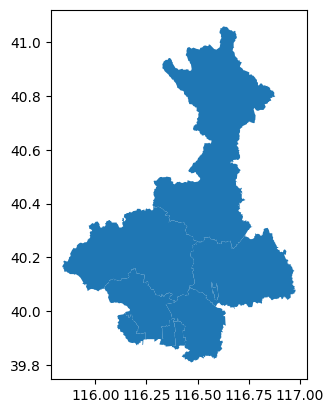

In [25]:
beijing_map.plot()
beijing_map.info()
beijing_map.head(9)

In [26]:
stations = ['Aotizhongxin', 'Changping', 'Dingling', 'Dongsi', 'Guanyuan', 'Gucheng', 'Huairou', 'Nongzhanguan', 'Shunyi', 'Tiantan', 'Wanliu', 'Wanshouxigong']
district = ['Chaoyang District', 'Changping District', 'Changping District', 'Dongcheng District', 'Xicheng District', 'Shijingshan District', 'Huairou District', 'Chaoyang District', 'Shunyi District', 'Dongcheng District', 'Haidian District', 'Xicheng District']
main_gdf = beijing_map.merge(main_df.merge(pd.DataFrame({'station': stations, 'district': district}), on='station', how='left'), left_on='shapeName', right_on='district', how='right')
main_gdf = main_gdf.drop(columns=['shapeName'])
main_gdf['district'] = main_gdf['district'].str.replace(' District', '', regex=False)
main_gdf = main_gdf[['geometry', 'district', 'station', 'datetime'] + [col for col in main_gdf.columns if col not in ['geometry', 'district', 'station', 'datetime']]]
main_gdf

,geometry,district,station,datetime,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,PI
0,"MULTIPOLYGON (((116.38455 40.03984, 116.38672 ...",Chaoyang,Aotizhongxin,2014-01-01,48.6,169.2,27.4,69.5,1406.2,18.8,2.7,1009.0,-10.6,0.0,1.3,5.59
1,"MULTIPOLYGON (((116.38455 40.03984, 116.38672 ...",Chaoyang,Aotizhongxin,2014-01-02,151.7,192.2,90.6,93.7,3437.5,1.2,2.1,1012.5,-6.5,0.0,1.0,13.66
2,"MULTIPOLYGON (((116.38455 40.03984, 116.38672 ...",Chaoyang,Aotizhongxin,2014-01-03,50.5,114.7,33.9,48.1,1083.3,25.0,4.1,1016.6,-10.8,0.0,2.1,4.90
3,"MULTIPOLYGON (((116.38455 40.03984, 116.38672 ...",Chaoyang,Aotizhongxin,2014-01-04,121.5,158.2,55.2,78.6,2304.2,1.1,-0.8,1016.7,-5.1,0.0,1.3,10.89
4,"MULTIPOLYGON (((116.38455 40.03984, 116.38672 ...",Chaoyang,Aotizhongxin,2014-01-05,90.1,116.8,42.4,70.7,1850.0,11.2,0.5,1018.7,-8.7,0.0,1.7,8.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13147,"POLYGON ((116.37473 39.97123, 116.38791 39.971...",Xicheng,Wanshouxigong,2016-12-27,41.0,54.6,7.4,48.5,570.8,26.5,-0.9,1030.4,-15.1,0.0,2.1,3.81
13148,"POLYGON ((116.37473 39.97123, 116.38791 39.971...",Xicheng,Wanshouxigong,2016-12-28,76.6,84.2,8.8,46.5,770.8,22.8,-0.8,1028.6,-13.6,0.0,2.7,6.69
13149,"POLYGON ((116.37473 39.97123, 116.38791 39.971...",Xicheng,Wanshouxigong,2016-12-29,71.8,99.0,14.0,62.9,850.0,22.8,-1.2,1031.0,-16.5,0.0,1.6,6.50
13150,"POLYGON ((116.37473 39.97123, 116.38791 39.971...",Xicheng,Wanshouxigong,2016-12-30,295.8,325.9,17.2,119.2,3520.8,7.4,-3.1,1025.4,-9.5,0.0,1.1,25.24


**Insight:**
- Pada tahap ini, dilakukan pemetaan berdasarkan stasiun cuaca dengan distrik lokasi stasiun cuaca tesebut

### Membuat dataframe untuk rata-rata bulanan

In [27]:
monthly_avg = main_gdf.groupby(['geometry', 'district', pd.to_datetime(main_gdf['datetime']).dt.to_period('M')]).agg({'PI': 'mean',
                                                                                                                      'TEMP': 'mean',
                                                                                                                      'PRES': 'mean',
                                                                                                                      'DEWP': 'mean',
                                                                                                                      'RAIN': 'mean',
                                                                                                                      'WSPM': 'mean'}).reset_index()
monthly_avg['datetime'] = monthly_avg['datetime'].dt.to_timestamp()
monthly_avg_gdf = gpd.GeoDataFrame(monthly_avg, geometry=monthly_avg['geometry'])
monthly_avg_gdf.to_file('./dashboard/main_data.shp')

c:\Users\kurni\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Field datetime create as date field, though DateTime requested.
  ogr_write(


**Insight:**
- Untuk stasiun yang berbeda namun pada distrik yang sama, dilakukan rata-rata pada setiap parameternya

## Visualization & Explanatory Analysis

### Bagaimana korelasi antar konsentrasi polutan dengan faktor atmosfer?

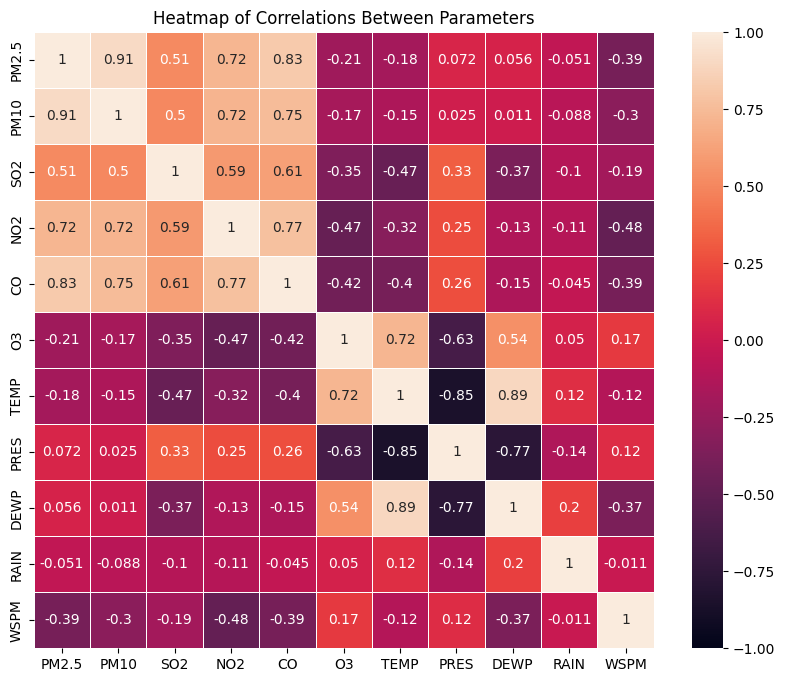

In [28]:
corr_matrix = main_df[['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, linewidths=0.5, vmin=-1, vmax=1)
plt.title('Heatmap of Correlations Between Parameters')
plt.show()

**Insight:**
- Kelompok polutan PM2.5, PM10, SO2, NO2, dan CO memiliki korelasi positif yang sangat kuat satu sama lain. Ini mengindikasikan bahwa peningkatan konsentrasi salah satu polutan ini cenderung diikuti oleh peningkatan konsentrasi polutan lainnya. Hal ini menunjukkan adanya sumber emisi yang sama atau proses kimia yang saling terkait dalam pembentukan polutan-polutan tersebut, misalnya pembakaran bahan bakar fosil
- Suhu memiliki korelasi yang positif dengan ozon yang menunjukkan bahwa ozon cenderung lebih tinggi pada suhu yang lebih tinggi karena ozon terbentuk lebih cepat dalam kondisi panas dan cerah. Sebaliknya, suhu memiliki korelasi negatif dengan polutan lain (PM2.5, PM10, SO2, NO2, dan CO) yang menunjukkan bahwa polutan-polutan ini cenderung lebih tinggi pada suhu yang lebih rendah seperti musim dingin
- Terdapat korelasi negatif yang kuat antara ozon dengan polutan lainnya. Ini menunjukkan bahwa pembentukan ozon di atmosfer dapat mengkonsumsi polutan lain
- Kelembaban dan curah hujan memiliki korelasi positif yang moderat yang menunjukkan bahwa peningkatan kelembaban cenderung diikuti oleh peningkatan curah hujan
- Kecepatan angin memiliki korelasi negatif yang lemah hingga sedang dengan PM2.5, PM10, NO2, dan CO. Ini menunjukkan bahwa angin membantu mengurangi konsentrasi polutan tersebut karena menyebarkannya ke area yang lebih luas
- Memahami hubungan antara berbagai polutan dan faktor lingkungan dapat membantu dalam merancang strategi pengendalian polusi yang efektif. Misalnya, jika diketahui bahwa peningkatan suhu berkontribusi pada peningkatan konsentrasi ozon, maka upaya untuk mengurangi emisi prekursor ozon pada saat suhu tinggi dapat menjadi salah satu strategi yang efektif

### Bagaimana pola fluktuasi kualitas udara di Beijing selama periode 2014 hingga 2016?

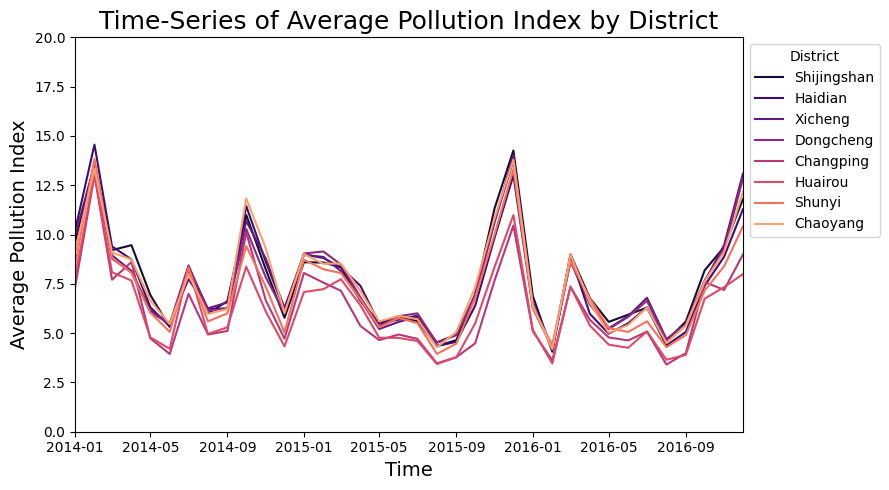

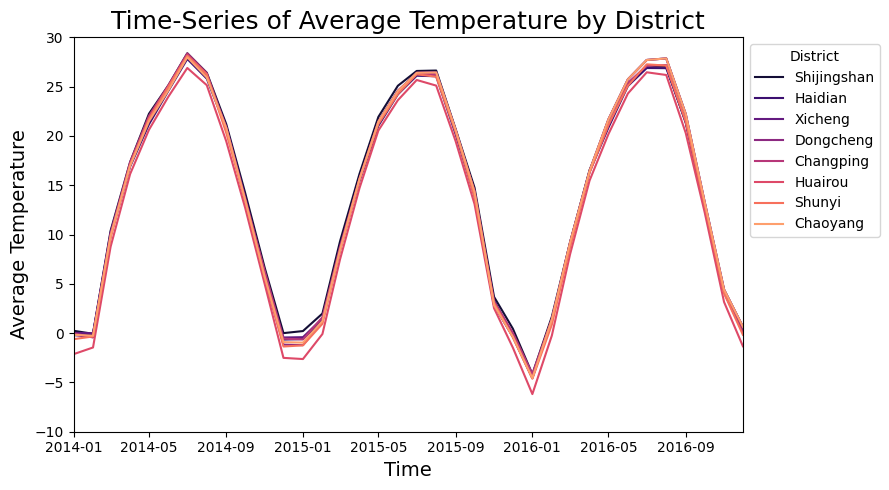

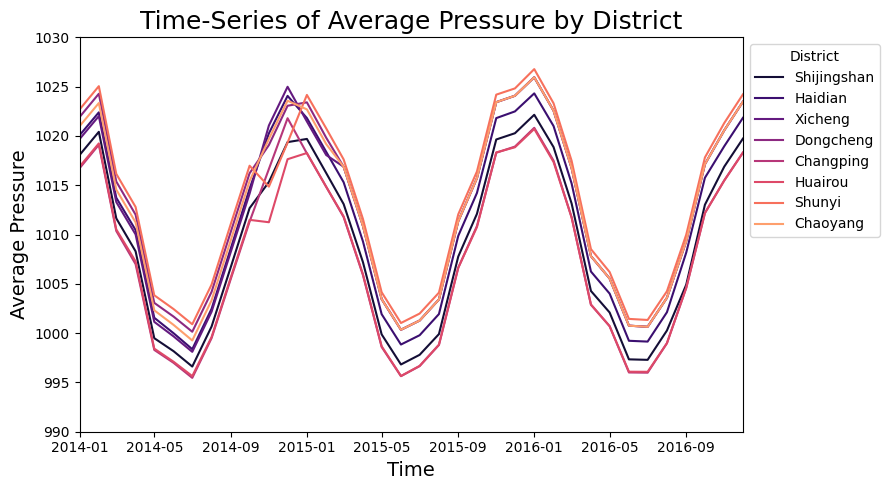

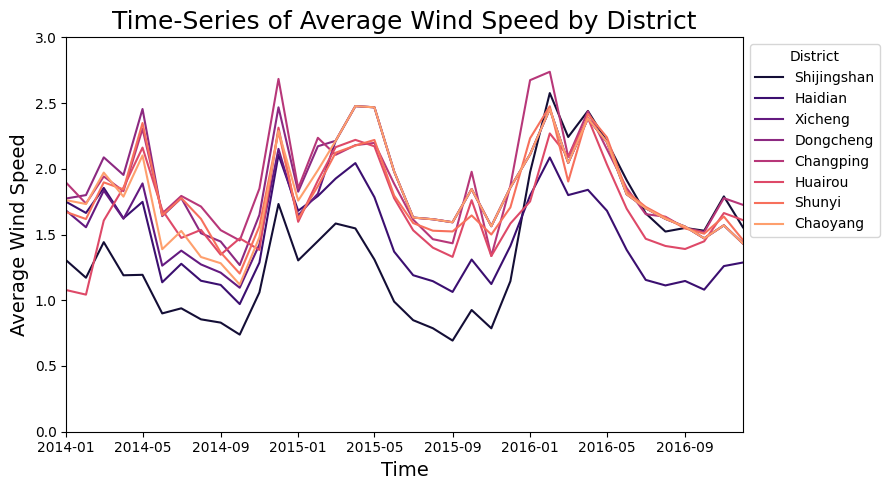

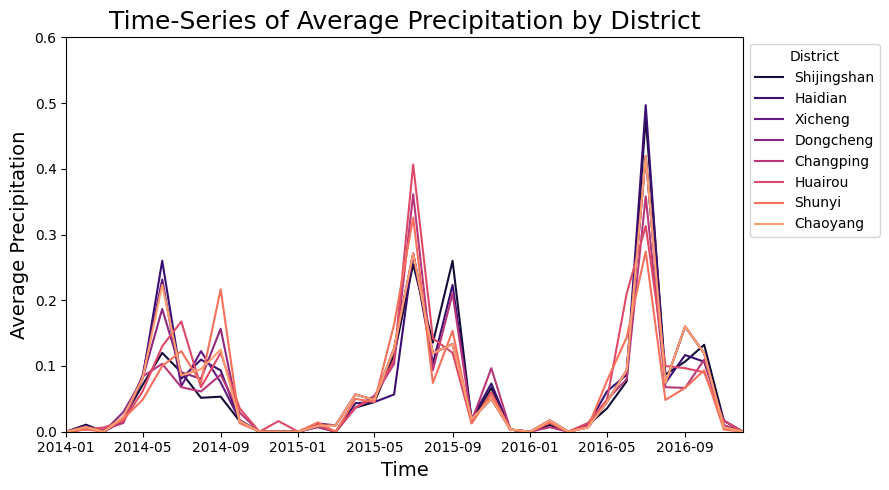

In [29]:
features = {'PI': ('Average Pollution Index', (0, 20)),
            'TEMP': ('Average Temperature', (-10, 30)),
            'PRES': ('Average Pressure', (990, 1030)),
            'WSPM': ('Average Wind Speed', (0, 3)),
            'RAIN': ('Average Precipitation', (0, 0.6))}
for feature, (ylabel, ylim) in features.items():
    plt.figure(figsize=(9, 5))
    colors = plt.cm.magma(np.linspace(0.1, 0.8, len(monthly_avg['district'].unique())))
    for i, district in enumerate(monthly_avg['district'].unique()):
        district_data = monthly_avg[monthly_avg['district'] == district]
        plt.plot(district_data['datetime'], district_data[feature], label=district, color=colors[i])
    plt.xlabel('Time', fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.xlim(pd.to_datetime('2014-01-01'), pd.to_datetime('2016-12-01'))
    plt.ylim(*ylim)
    plt.title(f'Time-Series of {ylabel} by District', fontsize=18)
    plt.legend(title='District', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()

C:\Users\kurni\AppData\Local\Temp\ipykernel_25980\1915827906.py:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


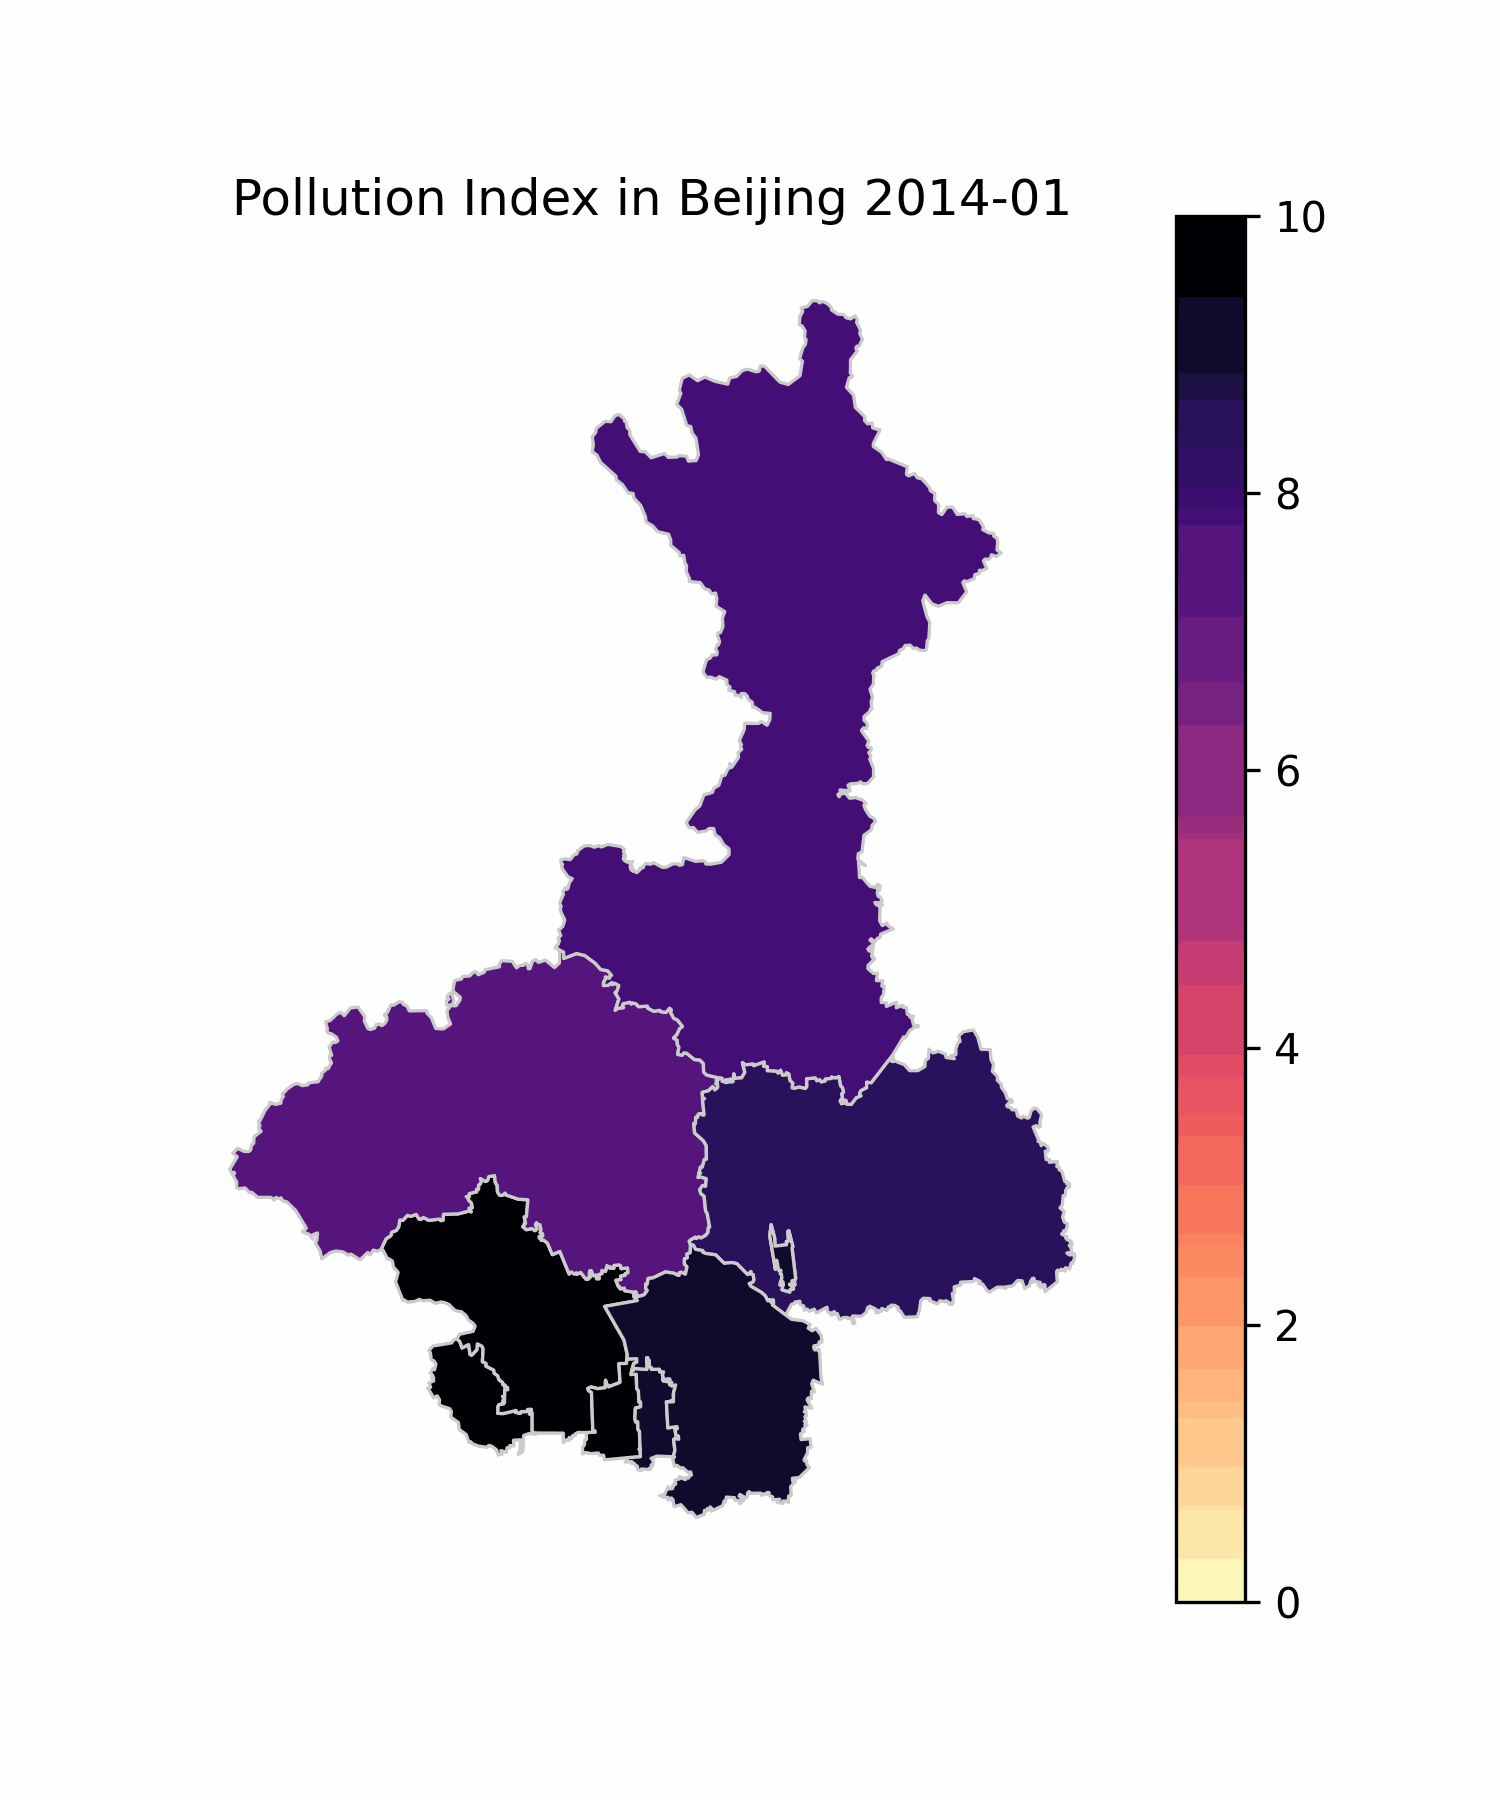

In [30]:
vmin, vmax = 0, 10
for monhth in monthly_avg_gdf['datetime'].unique():
    fig = monthly_avg_gdf[monthly_avg_gdf['datetime'] == monhth].plot(column='PI', cmap='magma_r', figsize=(5, 6),
                                                                            linewidth=0.8, edgecolor='0.8', vmin=vmin, vmax=vmax,
                                                                            legend=True, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    fig.axis('off')
    fig.set_title(f'Pollution Index in Beijing {monhth.strftime("%Y-%m")}')
    chart = fig.get_figure()
    chart.savefig(f'./charts/{monhth.strftime("%Y-%m")}.png', dpi=300)
    plt.close()
image_files = [os.path.join('./charts/', img) for img in sorted(os.listdir('./charts/')) if img.endswith('.png')]
with imageio.get_writer('./charts/pollution_animation.gif', mode='I', fps=1, loop=0) as writer:
    for filename in image_files:
        image = imageio.imread(filename)
        writer.append_data(image)
Image(filename='./charts/pollution_animation.gif', width=500)

**Insight:**
- Selama periode Januari hingga Maret dan Oktober hingga Desember, Beijing mengalami lonjakan polusi yang signifikan, terutama disebabkan oleh suhu rendah yang memerangkap polutan seperti PM2.5, PM10, SO2, NO2, dan CO di dekat permukaan tanah. Penggunaan alat pemanas berbahan bakar fosil selama musim dingin berkontribusi pada emisi polutan ini, dan korelasi positif yang kuat di antara kelompok polutan menunjukkan bahwa mereka kemungkinan berasal dari sumber yang sama. Kombinasi antara kondisi cuaca dan pola pembakaran ini memperburuk kualitas udara, mengakibatkan peningkatan tekanan udara yang berpotensi menghambat dispersi polutan selama bulan-bulan dingin
- Pada musim panas, suhu meningkat mendekati 30°C, yang berkontribusi pada peningkatan konsentrasi ozon (O₃) akibat reaksi kimia yang lebih cepat dalam kondisi panas dan cerah. Sementara itu, polutan lain seperti PM2.5, PM10, SO2, NO2, dan CO cenderung menurun, karena suhu tinggi menghambat akumulasi polutan tersebut. Lonjakan presipitasi yang terjadi dari Mei hingga September juga berperan penting dalam membersihkan udara, di mana hujan dan angin yang meningkat membantu menyebarkan polutan, sehingga mengurangi rata-rata indeks polusi di wilayah tersebut
- Kelembaban, curah hujan, dan kecepatan angin memiliki dampak signifikan terhadap kualitas udara di Beijing, terutama selama musim semi dan musim panas. Curah hujan membantu membersihkan udara dari polutan, sedangkan kecepatan angin yang lebih tinggi, terutama antara Januari dan Mei, berkontribusi pada penyebaran polutan seperti PM2.5 dan NO2, sehingga mengurangi konsentrasi mereka di atmosfer. Korelasi negatif antara kecepatan angin dan polutan ini menegaskan pentingnya kondisi meteorologis dalam menjaga kualitas udara yang lebih baik, menunjukkan bahwa strategi mitigasi polusi harus mempertimbangkan faktor-faktor cuaca
- Meskipun pola polusi di Beijing menunjukkan kesamaan, terdapat variabilitas yang signifikan antar distrik. Distrik seperti Shijingshan dan Shunyi mengalami lonjakan polusi yang lebih tinggi pada beberapa periode, yang mungkin dipicu oleh tingkat industrialisasi dan kepadatan penduduk yang lebih tinggi. Sebaliknya, distrik Huairou yang terletak di daerah pegunungan menunjukkan indeks polusi yang lebih rendah, menggarisbawahi peran penting kondisi geografis dan jarak dari sumber emisi dalam memengaruhi kualitas udara. Oleh karena itu, pendekatan yang efektif dalam pengendalian polusi harus memperhitungkan karakteristik lokal dan lingkungan fisik masing-masing distrik

## Conclusion

- Pola hubungan antara polutan dan faktor lingkungan memberikan wawasan penting tentang bagaimana polutan terbentuk dan didispersikan. Polutan PM2.5, PM10, SO2, NO2, dan CO memiliki korelasi positif yang kuat, menunjukkan bahwa mereka berasal dari sumber yang sama, seperti pembakaran bahan bakar fosil. Di sisi lain, suhu mempengaruhi konsentrasi ozon, yang meningkat pada suhu tinggi, sementara polutan lainnya cenderung lebih tinggi pada suhu rendah, terutama di musim dingin. Kelembaban, curah hujan, dan angin memainkan peran penting dalam membersihkan udara dan menyebarkan polutan, dengan angin yang membantu mengurangi akumulasi polusi. Memahami korelasi ini memungkinkan perancangan strategi pengendalian polusi yang lebih efektif, seperti fokus pada pengurangan emisi ozon pada suhu tinggi dan memperhatikan faktor meteorologis untuk mengendalikan konsentrasi polutan lainnya
- Kualitas udara di Beijing sangat dipengaruhi oleh faktor musiman, meteorologis, dan geografis. Selama musim dingin, polusi meningkat akibat suhu rendah yang memerangkap polutan dari pembakaran bahan bakar fosil, memperparah kualitas udara. Sebaliknya, pada musim panas, suhu tinggi mempercepat pembentukan ozon, tetapi mengurangi konsentrasi polutan lain berkat peningkatan presipitasi dan angin. Faktor cuaca seperti kelembaban, hujan, dan angin berperan penting dalam membersihkan udara selama musim semi dan musim panas, membantu menyebarkan polutan. Selain itu, perbedaan geografis antar distrik, seperti Huairou yang lebih bersih dibandingkan distrik-distrik industri seperti Shijingshan, menunjukkan bahwa karakteristik lokal perlu dipertimbangkan dalam strategi pengendalian polusi yang efektif